In [2]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""
# %load_ext autoreload
# %autoreload
import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked

import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops

from sklearn.model_selection import train_test_split

from tqdm import tqdm
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader
from src.data.data_processing import standardise_embeddings, convert_networkx_to_torch, get_mask
from src.visualization.visualize import tsne, plot_metrics_during_training

from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")


def train(model: torch.nn.Module, data: list[Data], optimizer, criterion):
    """
    Perform one training iteration of the model.

    Args:
        model ():
        data ():
        optimizer ():
        criterion ():

    Returns:

    """
    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    model.train()
    optimizer.zero_grad()
    out = model(*data_inputs)
    loss = criterion(out[data[0].train_mask], data[0].y[data[0].train_mask])
    loss.backward()
    optimizer.step()
    return loss


def evaluate_metrics(model: torch.nn.Module, data: list[Data], dataset: str = 'test', show: bool = False) -> dict:
    """
    Calculate the different metrics for the specified dataset.

    Args:
        model (torch.nn.Module): The initiated model
        data (Data): The Torch dataset
        dataset (str): The dataset to specify the metrics for

    Returns:
        Dictionary with the metrics
    """
    if dataset == 'test':
        mask = data[0].test_mask
    elif dataset == 'train':
        mask = data[0].train_mask
    else:
        assert False, f'Dataset {dataset} not recognised. Should be "train" or "test".'
    model.eval()

    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    out = model(*data_inputs)
    pred = out

    metric_calculator = Metrics(pred[mask].detach().numpy(), data[0].y[mask].detach().numpy(),
                                threshold=0.5)
    metrics = metric_calculator.retrieve_all_metrics()
    
    if show:
        print('The metrics: ', metrics)

    return metrics


def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels,
                        heads=model_parameters['heads'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "dualGCN", "dualGAT", "SAGE"]'

    return model

Data(x=[56000, 768], edge_index=[2, 221184], y=[56000, 52], train_mask=[56000], test_mask=[56000], edge_weight=[120559], batch_size=64, negative_edge_index=[2, 110592])
tensor([[38351, 38352, 38354,  ..., 55997, 55998, 55999],
        [38352, 38351,  4920,  ..., 55997, 55998, 55999]])
cpu
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
[Data(x=[56000, 768], edge_index=[2, 221184], y=[56000, 52], train_mask=[56000], test_mask=[56000], edge_weight=[120559], batch_size=64, negative_edge_index=[2, 110592])]


Train acc: 0.9639168977737427, Train loss: 0.19091902673244476: 100%|██████████| 299/299 [18:17<00:00,  3.67s/it]


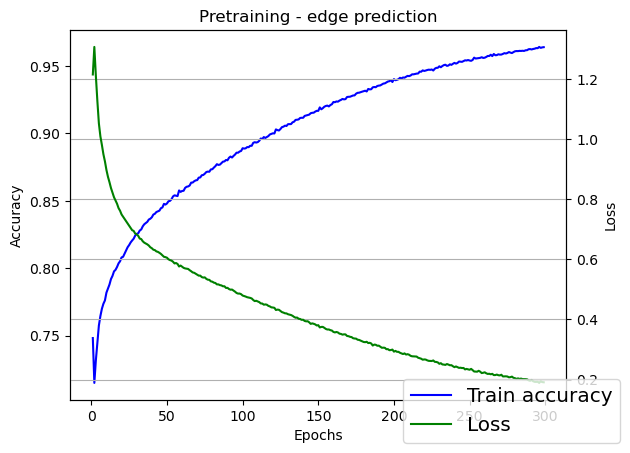

In [18]:
from src.models.pretraining import NegativeEdge, BatchAE, train_pretrain, DataLoaderAE
print(author_data)



transform =  NegativeEdge()
transformed_author_data = transform(author_data)

#set up optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
criterion_pretrain = torch.nn.BCEWithLogitsLoss()

#optimizer = optim.Adam(model.graph_pred_linear.parameters(), lr=args.lr, weight_decay=args.decay)    


train_acc = 0
train_losses = []
train_accs = []
for epoch in (pbar := tqdm(range(1, 300))):
    model, train_acc, train_loss = train_pretrain(model, device, None, optimizer, BatchAE([transformed_author_data]).batch[0], criterion_pretrain)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    pbar.set_description(f'Train acc: {train_acc}, Train loss: {train_loss}')

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(train_losses) + 1),train_accs , label='Train accuracy', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(np.arange(1, len(train_accs) + 1), train_losses, label='Loss', c='green')

plt.title(f'Pretraining - edge prediction')
fig.legend(loc='lower right', fontsize='x-large')
plt.grid()
plt.show()

torch.save(model, cc_path(f'models/pretrained_graphs/pretained_{gnn_type}_{"-".join(data_type_to_use)}_{embedding_type}.pt'))

## Set model parameters

In [2]:
# current models to choose from: ["GCN", "GAT", "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific"]

gnn_type = 'GAT'
subsample_size = 56000
data_type_to_use = ['author']
embedding_type = 'scibert'

all_model_parameters = {
    "GAT": {
        'hidden_channels': 64,
        'heads': 8
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGCN": {
        'hidden_channels': 32
    },
}

## Load and process the data

In [3]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_20230413.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [4]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

print('Start processing data...')
print('Standardising embeddings...') 


# process the labels we want to select now

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

# label_columns = processed_df.loc[:, ['pui', 'human', 'mouse', 'rat', 'nonhuman',
#                                      'controlled study', 'animal experiment']]
label_columns[label_columns.columns.difference(['pui'])] = label_columns[
    label_columns.columns.difference(['pui'])].astype(str)
features = ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization',
            'chemicals',
            'num_refs', 'date-delivered', 'labels_m', 'labels_a']

# drop all nodes that do not have an embedding
# nodes_to_remove = []
# for network in [author_networkx, keyword_network]:
#     nodes_to_remove += [node for node in list(network.nodes) if not node in embedding_df.pui.to_list()]
#
# for node in nodes_to_remove:
#     for network in [author_networkx, keyword_network]:
#         network.remove_node(node)

Start processing data...
Standardising embeddings...


/tmp/ipykernel_5200/511798419.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_columns[label_columns.columns.difference(['pui'])] = label_columns[


In [5]:
to_remove = [(a,b) for a, b, attrs in keyword_network.edges(data=True) if attrs["weight"] < 1/200]
keyword_network.remove_edges_from(to_remove)

In [6]:
len(list(set(embedding_df.pui.to_list())))

117310

In [7]:
print(len(list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.astype(str).to_list()))))
print(len(list(set(embedding_df.pui.astype(str).to_list()) & set(keyword_network.nodes))))

print(len(author_networkx.nodes))
print(len(keyword_network.nodes))
print(len(author_networkx.edges))
print(len(keyword_network.edges))

56337
96163
71727
97196
163133
542224


In [8]:
# get down-sampled networks
print('Sampling the graphs...')
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
print('keyword', len(set(keyword_network.nodes)))
print('author', len(set(author_networkx.nodes)))
print('embedding', len(set(embedding_df.pui.to_list())))

sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))

Sampling the graphs...
keyword 97196
author 71727
embedding 117310


In [9]:
inverse_node_label_mapping = inv_map = {v: k for k, v in node_label_mapping.items()}


In [10]:
def write_indices_to_txt(indices, data_set):
    # open file in write mode
    with open(cc_path(f'data/{data_set}_indices.txt'), 'w') as fp:
        for item in indices:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [11]:
train_indices, test_indices = train_test_split(range(len(sampled_author)), test_size=0.2, random_state=0)
train_indices, val_indices = train_test_split(range(len(train_indices)), test_size=0.2, random_state=0)

# write_indices_to_txt(list(map(inverse_node_label_mapping.get, train_indices)), data_set='train')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, test_indices)), data_set='test')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, val_indices)), data_set='val')

# import json
# with open(cc_path("data/inverse_pui_idx_mapping.json"), "w") as outfile:
#     json.dump(inverse_node_label_mapping, outfile)
    
# with open(cc_path("data/pui_idx_mapping.json"), "w") as outfile:
#     json.dump(node_label_mapping, outfile)

In [12]:
# import json

# with open(cc_path("data/pui_idx_mapping.json"), "r") as outfile:
#     node_label_mapping = json.load(outfile)
    
# with open(cc_path(f'data/train_indices.txt')) as f:
#     train_puis = f.read().splitlines()
#     train_indices = list(map(node_label_mapping.get, train_puis))
# with open(cc_path(f'data/val_indices.txt')) as f:
#     val_puis = f.read().splitlines()
#     val_indices = list(map(node_label_mapping.get, val_puis))
# with open(cc_path(f'data/test_indices.txt')) as f:
#     test_puis = f.read().splitlines()
#     test_indices = list(map(node_label_mapping.get, test_puis))

    

In [13]:
# create train and test split
print('Creating torch datasets...')

train_mask = get_mask(train_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = convert_networkx_to_torch(sampled_author, embedding_df, processed_df, train_mask, test_mask,
                                 node_label_mapping, embedding_type)
keyword_data = convert_networkx_to_torch(sampled_keyword, embedding_df, processed_df, train_mask, test_mask,
                                  node_label_mapping, embedding_type)

Creating torch datasets...


In [17]:
from torch_geometric.utils import contains_self_loops,is_undirected
is_undirected(author_data.edge_index)

False

In [18]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class ResidualConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(ResidualConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[-2]

class InitialConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(InitialConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[0]
    
class DenseConnection(torch.nn.Module):
    def __init__(self, in_dim, out_dim, aggregation='concat'):
        super(DenseConnection, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.aggregation = aggregation
        if aggregation == 'concat':
            self.layer_transform = torch.nn.Linear(in_dim, out_dim, bias=True)
        elif aggregation == 'attention':
            self.layer_att = torch.nn.Linear(512, 1, bias=True)

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        if self.aggregation == 'concat':
            X = torch.cat(Xs, dim=-1)
            X = self.layer_transform(X)
            return X
        elif self.aggregation == 'maxpool':
            X = torch.stack(Xs, dim=-1)
            X, _ = torch.max(X, dim=-1, keepdim=False)
            return X
        # implement with the code from https://github.com/mengliu1998/DeeperGNN/blob/master/DeeperGNN/dagnn.py
        elif self.aggregation == 'attention':
            # pps n x k+1 x c
            pps = torch.stack(Xs, dim=1)
            retain_score = self.layer_att(pps).squeeze()
            retain_score = torch.sigmoid(retain_score).unsqueeze(1)
            X = torch.matmul(retain_score, pps).squeeze()
            return X
        else:
            raise Exception("Unknown aggregation")

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_heads):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=num_heads))
        for i in range(2, num_layers):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))
        self.conv_last = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads)
        
        self.lin1 = torch.nn.Linear(hidden_channels*num_heads, out_channels)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        # self.skip_layers = DenseConnection(hidden_channels * num_heads * (num_layers-1), out_channels, aggregation='attention')
        self.skip_layers = InitialConnection(alpha=0.5)

        
    def forward(self, x, edge_index):
        xs = []
        x1 = F.dropout(torch.relu(self.convs[0](x, edge_index)), p=0.6, training=self.training)
        xs.append(x1)
        x_new = x1

        for i in range(self.num_layers - 2):
            x_new = F.dropout(torch.relu(self.convs[i+1](x_new, edge_index)), p=0.1, training=self.training)
            xs.append(x_new)
        x_last = self.skip_layers(xs)
        
        x = F.relu(self.lin1(x_last))
        x = self.lin2(x)
        x = self.sigmoid(x)

        return x

    
model = GNN(author_data.x.shape[1], 64, 52, 4, 4)

In [22]:
"""This file defines the GAT single stream model."""

from torch_geometric.nn import GATv2Conv
import torch
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_labels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads)
        self.conv2 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
        self.conv3 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
        self.convend = GATv2Conv(heads * hidden_channels, num_labels, 1)
        
        self.linear_final_1 = torch.nn.Linear(hidden_channels*heads, num_labels*10)
        self.linear_final_2 = torch.nn.Linear(num_labels*10, num_labels*5)
        self.linear_final_3 = torch.nn.Linear(num_labels*5, num_labels)

        # self.self_attention_layer = torch.nn.MultiheadAttention(num_labels, num_heads=1, dropout=0.1)


    def forward(self, x, edge_index):
        x = F.dropout(x.float(), p=0.1, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        # x = F.dropout(x, p=0.1, training=self.training)
        
        # x = F.elu(x)
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.conv3(x, edge_index)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.convend(x, edge_index)
        
        x = self.linear_final_1(x)
        x = F.elu(x)

        x = self.linear_final_2(x)
        x = F.elu(x)

        x = self.linear_final_3(x)
        # x, _ = self.self_attention_layer(x, x, x)

        return torch.sigmoid(x)
    
    
# """This file defines the GAT single stream model."""

# from torch_geometric.nn import GATv2Conv
# import torch
# import torch.nn.functional as F


# class GAT(torch.nn.Module):
#     def __init__(self, hidden_channels, num_features, num_labels, heads):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GATv2Conv(num_features, hidden_channels, heads)
#         self.conv2 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
#         self.conv3 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
#         self.convend = GATv2Conv(heads * hidden_channels, num_labels, 1)
        
#         self.self_attention_layer = torch.nn.MultiheadAttention(num_labels, num_heads=1, dropout=0.1)


#     def forward(self, x, edge_index):
#         x = F.dropout(x.float(), p=0.2, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index)
#         # x = F.elu(x)
#         # x = F.dropout(x, p=0.2, training=self.training)
#         # x = self.conv3(x, edge_index)
#         # x = F.elu(x)
#         # x = F.dropout(x, p=0.2, training=self.training)
#         x = self.convend(x, edge_index)
        
#         x, _ = self.self_attention_layer(x, x, x)

#         return torch.sigmoid(x)

In [14]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)

In [29]:
print(model)

GAT(
  (conv1): GATv2Conv(768, 64, heads=8)
  (conv2): GATv2Conv(512, 64, heads=8)
  (conv3): GATv2Conv(512, 64, heads=8)
  (convend): GATv2Conv(512, 52, heads=1)
  (linear_final_1): Linear(in_features=512, out_features=520, bias=True)
  (linear_final_2): Linear(in_features=520, out_features=260, bias=True)
  (linear_final_3): Linear(in_features=260, out_features=52, bias=True)
  (linear_final_end): Linear(in_features=512, out_features=52, bias=True)
)


In [28]:
model.eval()

all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
print('This is the data object: ', data)
data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

# model.set_label_embeddings(*data_inputs[3:])

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())
# visualize(out, color=data.y.argmax(dim=1))

This is the data object:  [Data(x=[56000, 768], edge_index=[2, 221184], y=[56000, 52], train_mask=[56000], test_mask=[56000], edge_weight=[120559], batch_size=64, negative_edge_index=[2, 110592])]
The predictions of the test set before training:  [[0.40542895 0.47795215 0.52103895 ... 0.5208658  0.48875478 0.5422855 ]
 [0.4185336  0.45923385 0.52050847 ... 0.44682607 0.50507563 0.46882463]
 [0.5216767  0.52862495 0.49620783 ... 0.47240612 0.48120335 0.47447994]
 ...
 [0.48292923 0.5017552  0.5190369  ... 0.5150914  0.4560756  0.4996112 ]
 [0.42199275 0.4566122  0.47835815 ... 0.49110213 0.538568   0.4489209 ]
 [0.46847954 0.458133   0.47623342 ... 0.5131381  0.4558166  0.50387526]]


In [29]:
# set training parameters
print('Start training procedure...')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# label_occs = label_columns[label_columns.columns.difference(['pui'])].sum().to_list()
# weight = torch.tensor(label_occs) / sum(label_occs)

criterion = torch.nn.BCELoss()
# criterion = torch.nn.MultiLabelSoftMarginLoss()

Start training procedure...


In [32]:
# train model
all_metrics = evaluate_metrics(model, data, dataset='train').keys()
train_metrics_all = {key: [] for key in all_metrics}
test_metrics_all = {key: [] for key in all_metrics}
loss_all = []

num_epochs = 300
for epoch in (pbar := tqdm(range(1, num_epochs))):
    loss = train(model, data, optimizer, criterion)

    train_metrics = evaluate_metrics(model, data, dataset='train', show=False)
    test_metrics = evaluate_metrics(model, data, dataset='test', show=False)

    for metric in train_metrics.keys():
        train_metrics_all[metric].append(train_metrics[metric])
        test_metrics_all[metric].append(test_metrics[metric])

    loss_all.append(loss.item())
    pbar.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(test_metrics)

Epoch: 299, Loss: 0.1144: 100%|██████████| 299/299 [1:20:32<00:00, 16.16s/it]

{'Precision': [0.6256410256410256, 0.8002686108979279, 0.6795481569560048, 0.6731707317073171, 0.8555632342778162, 0.8331539289558665, 0.7660878447395302, 0.8333333333333334, 0.8834459459459459, 0.7446808510638298, 0.7662152530292231, 0.6078431372549019, 0.6245353159851301, 0.0, 0.7594086021505376, 0.6177606177606177, 1.0, 0.6756756756756757, 0.6923076923076923, 0.4444444444444444, 0.8572891771935814, 0.5, 0.9521105899777833, 0.7431693989071039, 0.6551724137931034, 0.681214421252372, 0.546875, 0.7142857142857143, 0.7891373801916933, 0.8351278600269179, 0.625, 0.6011904761904762, 0.8042328042328042, 0.7333333333333333, 0.64, 0.8797385620915033, 0.5151515151515151, 0.6666666666666666, 0.0, 0.5714285714285714, 0.0, 0.0, 0.0, 0.5882352941176471, 0.7135678391959799, 0.746268656716418, 0.6847161572052402, 0.45454545454545453, 0.0, 0.6805555555555556, 0.75, 0.0], 'Recall': [0.1750358680057389, 0.8061461151913413, 0.49013722126929676, 0.3129251700680272, 0.7364663890541344, 0.6323529411764706,

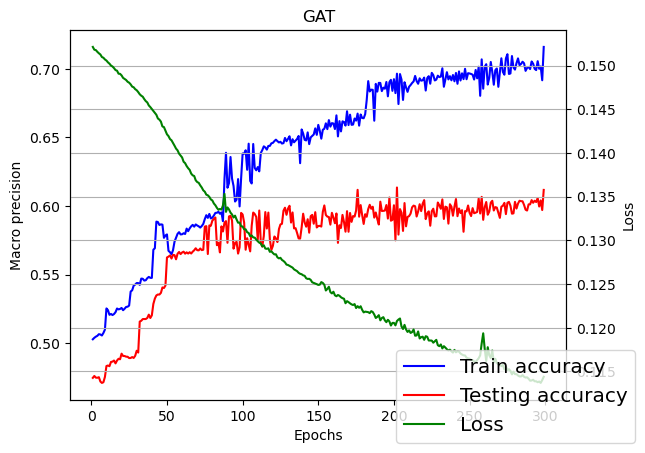

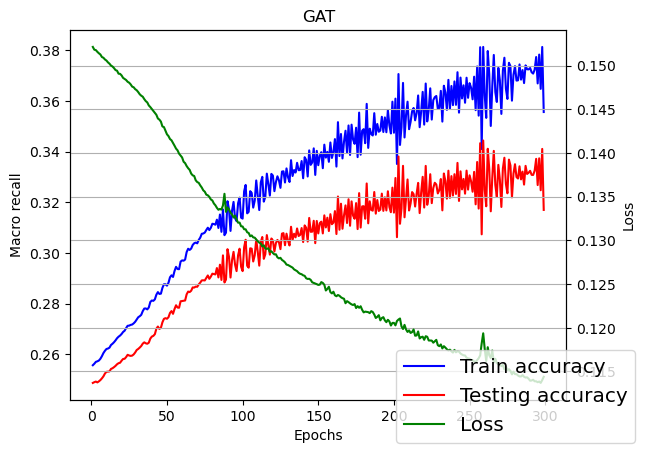

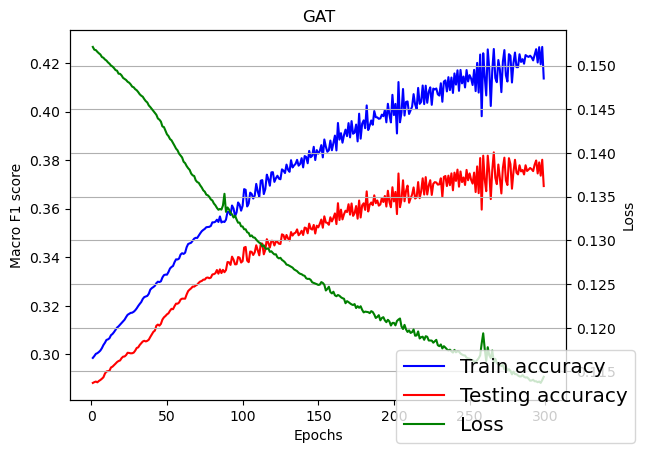

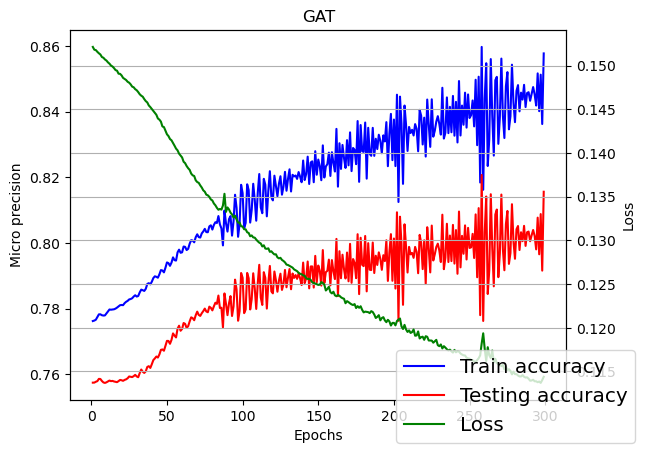

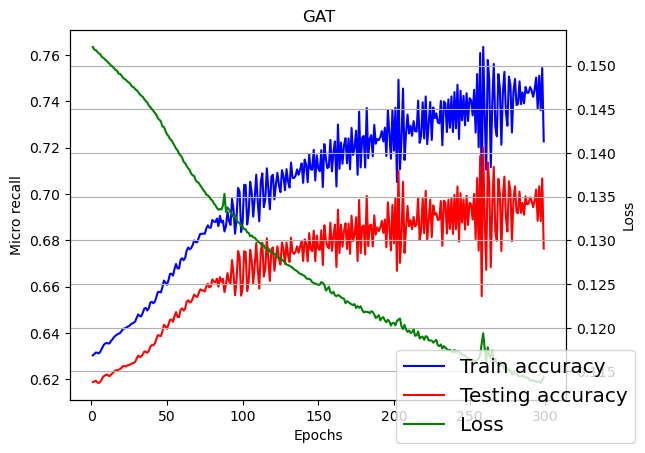

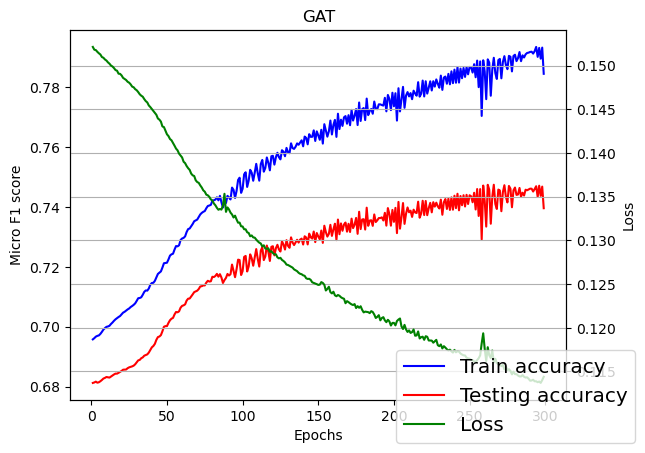

The predictions of the test set before training:  [[1.0207051e-03 3.8959919e-03 1.3840661e-03 ... 5.4412562e-04
  5.0894328e-04 1.5088179e-03]
 [3.2449332e-03 2.5166893e-02 5.1275757e-03 ... 3.1152036e-04
  1.1593562e-03 3.8315225e-03]
 [4.0057845e-02 9.5041168e-01 7.2389162e-01 ... 4.4212863e-03
  4.9354941e-02 2.4708282e-02]
 ...
 [1.2823774e-03 1.3364752e-02 6.8845190e-02 ... 1.9221682e-03
  1.7442157e-02 2.2632182e-03]
 [3.9687155e-05 8.4232719e-04 1.8602860e-04 ... 1.6712938e-02
  5.4601151e-05 1.2066207e-04]
 [7.7317511e-03 6.3664567e-01 2.9002979e-01 ... 1.3242288e-03
  2.0001553e-02 2.4209924e-02]]
Evaluating model performance...
The metrics:  {'Precision': [0.7176820208023774, 0.8332460275886153, 0.712372790573112, 0.7214377406931964, 0.9235707121364092, 0.8974358974358975, 0.8152737752161383, 0.7419354838709677, 0.9337960491190603, 0.8103837471783296, 0.8488423864648263, 0.7220543806646526, 0.6839887640449438, 0.0, 0.7917935632562351, 0.7368421052631579, 1.0, 0.68669527896995

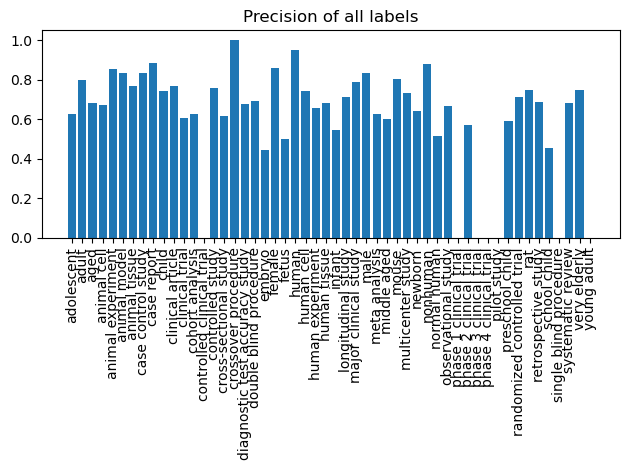

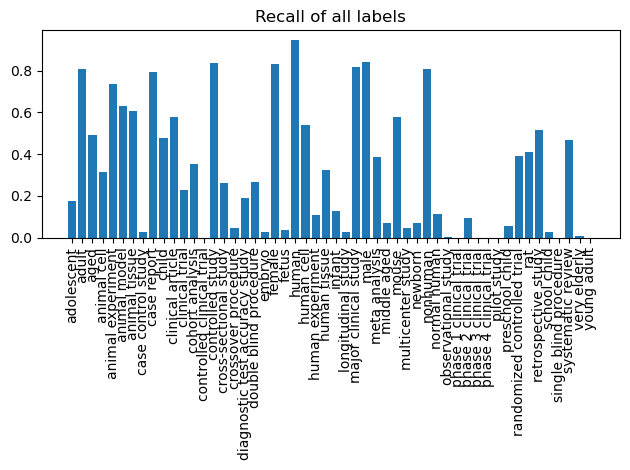

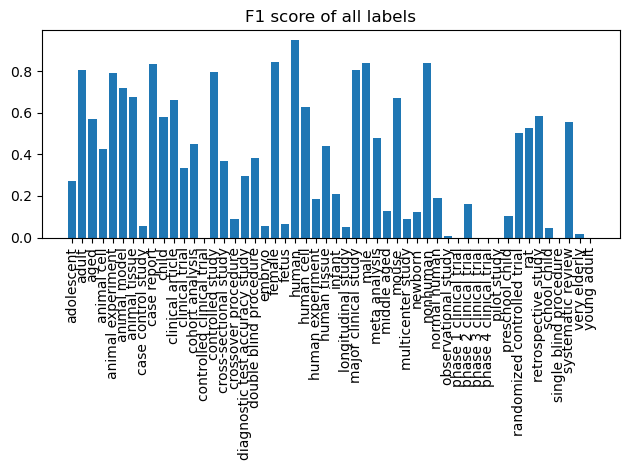

In [38]:
today = datetime.date.today()
now = datetime.datetime.now()
time = now.strftime("%H-%M-%S")

image_path = cc_path(f'reports/figures/classification_results/{today}/')
if not os.path.exists(image_path):
    os.mkdir(image_path)
os.mkdir(image_path + f'{time}/')
for metric in all_metrics:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(train_metrics_all[metric], test_metrics_all[metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)


# get output from trained model
model.eval()
out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())

# get the test accuracy
print('Evaluating model performance...')
train_end_metrics = evaluate_metrics(model, data, dataset='train', show=True)
test_end_metrics = evaluate_metrics(model, data, dataset='test', show=True)


for metric in all_metrics:
    if not 'Micro' in metric and not 'Macro' in metric:
        plt.figure()
        plt.title(f'{metric} of all labels')
        plt.bar(range(len(label_columns.columns.difference(['pui']))), test_end_metrics[metric], tick_label=label_columns.columns.difference(['pui']))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{gnn_type}_{metric}_label.png'))
        plt.show()

# print(f'Test Accuracy: {test_acc:.4f}')

# visualize(out, color=data.y.argmax(dim=1))

In [43]:
data_for_logreg_X, data_for_logreg_y = embedding_df.loc[embedding_df['pui'].isin(sampled_nodes), embedding_df.columns.difference(['pui'])].to_numpy(), \
                                       label_columns.loc[label_columns['pui'].isin(sampled_nodes), label_columns.columns.difference(['pui'])].to_numpy()

In [48]:
data_for_logreg_X_train, data_for_logreg_X_test = data_for_logreg_X[train_indices, :], data_for_logreg_X[test_indices, :]
data_for_logreg_y_train, data_for_logreg_y_test = data_for_logreg_y[train_indices, :].astype(int), data_for_logreg_y[test_indices, :].astype(int)

In [49]:
data_for_logreg_y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

In [22]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as gbm

clf = OneVsRestClassifier(gbm.LGBMClassifier(n_jobs=-1, n_estimators=500))
clf = clf.fit(data_for_logreg_X_train, data_for_logreg_y_train)


NameError: name 'data_for_logreg_X_train' is not defined

In [23]:
y_test_pred = clf.predict(data_for_logreg_X_test)

NameError: name 'data_for_logreg_X_test' is not defined

In [31]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f'Macro - F1: {f1_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - F1: {f1_score(data_for_logreg_y_test, y_test_pred, average="micro")}')
print(f'Macro - recall: {recall_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - recall: {recall_score(data_for_logreg_y_test, y_test_pred, average="micro")}')
print(f'Macro - precision: {precision_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - precision: {precision_score(data_for_logreg_y_test, y_test_pred, average="micro")}')

NameError: name 'data_for_logreg_y_test' is not defined

In [ ]:
graph_created_embeddings = model.forward(data_inputs[0], data_inputs[1], return_embeddings=True)
X_train_graph_embeddings = graph_created_embeddings[author_data.train_mask].detach().numpy()
X_test_graph_embeddings = graph_created_embeddings[author_data.test_mask].detach().numpy()
y_train_graph_embeddings = author_data.y[author_data.train_mask].detach().numpy()
y_test_graph_embeddings = author_data.y[author_data.test_mask].detach().numpy()

In [35]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as gbm

clf = MultiOutputClassifier(gbm.LGBMClassifier(n_jobs=-1, n_estimators=500))
clf = clf.fit(X_train_graph_embeddings, y_train_graph_embeddings, callbacks = [gbm.log_evaluation()])


In [36]:
y_test_pred = clf.predict(X_test_graph_embeddings)


In [37]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f'Macro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="micro")}')

Macro - F1: 0.7138825575561533
Micro - F1: 0.8435020914467042
Macro - recall: 0.648897954112832
Micro - recall: 0.8198897093186279
Macro - precision: 0.8150302611322146
Micro - precision: 0.8685148514851485
